In [50]:
import pyupbit
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
mpl.rcParams['font.family'] = 'AppleGothic'   # Mac 기본 한글 폰트
mpl.rcParams['axes.unicode_minus'] = False    # 음수(-) 깨짐 방지

In [51]:
# 2️⃣ 조회할 시작일 (2025년 1월 1일)
start_date = "2025-01-01"

# 3️⃣ 현재 시각까지 4시간 간격 데이터 가져오기
df = pyupbit.get_ohlcv(
    ticker="KRW-BTC",       # 마켓
    interval="minute240",   # 240분 == 4시간봉
    to=datetime.now(),      # 끝 시점
    count=200,              # 한 번에 최대 200개
)

# 4️⃣ 여러 구간으로 나누어 조회하기
# 2025-01-01 이후 지금까지의 모든 4시간봉 데이터
# pyupbit는 최대 200개 캔들만 조회 가능 → 기간이 길면 반복 조회 필요
all_data = []
to = datetime.now()


while True:
    data = pyupbit.get_ohlcv("KRW-BTC", interval="minute240", to=to, count=200)
    if data is None or data.empty:
        break
    all_data.append(data)
    to = data.index[0]  # 이전 구간의 첫 번째 시점으로 갱신
    if to < pd.to_datetime(start_date):
        break

# 5️⃣ 전체 데이터 합치고 1월 이후만 필터링
df = pd.concat(all_data)
df = df[df.index >= pd.to_datetime(start_date)]
df.sort_index(inplace=True)


# 3️⃣ RSI 14 계산
delta = df["close"].diff()  # 종가 변화
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)

roll_up = pd.Series(gain).rolling(window=14).mean()
roll_down = pd.Series(loss).rolling(window=14).mean()

RS = roll_up / roll_down
RSI = 100.0 - (100.0 / (1.0 + RS))
df["RSI14"] = RSI.values


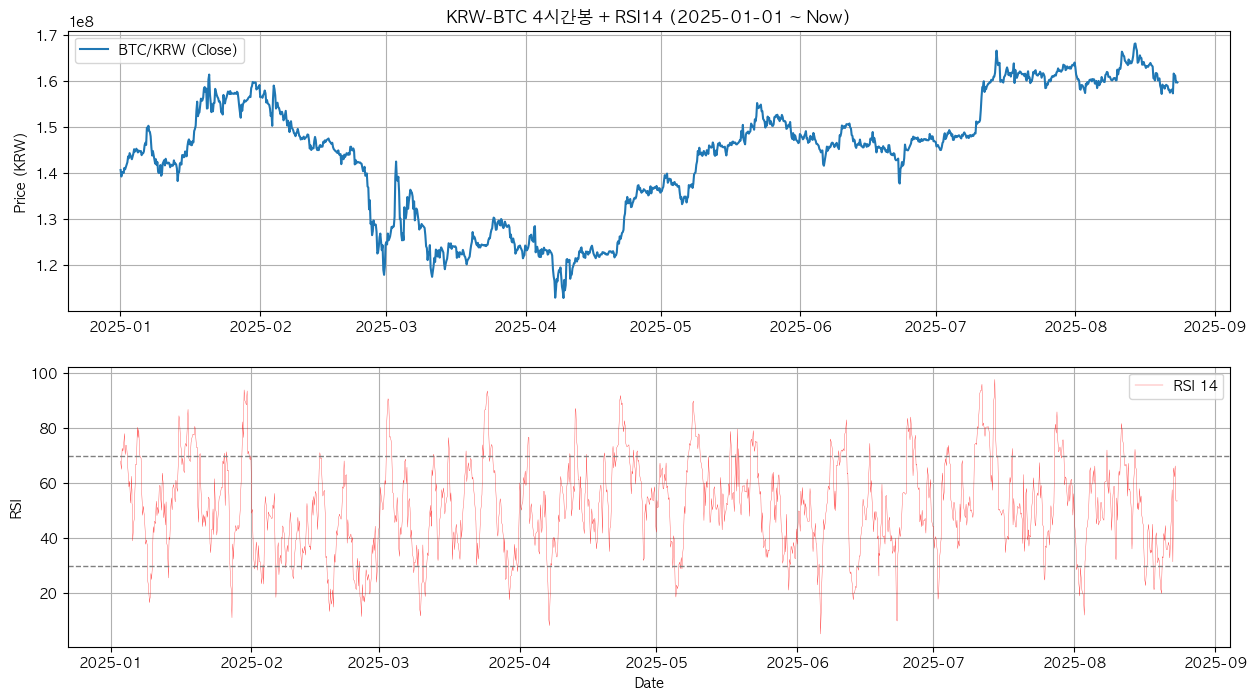

In [52]:
# (a) 가격 차트만 보기
# plt.figure(figsize=(12,6))
# plt.plot(df.index, df["close"], label="BTC/KRW (4H)")
# plt.title("KRW-BTC 4시간봉 (2025-01-01 ~ Now)")
# plt.xlabel("Date")
# plt.ylabel("Price (KRW)")
# plt.legend()
# plt.grid(True)
# plt.show()

# 가격차트 + RSI14 차트 
# 4️⃣ 차트 그리기
plt.figure(figsize=(15,8))

plt.subplot(2,1,1)
plt.plot(df.index, df["close"], label="BTC/KRW (Close)")
plt.title("KRW-BTC 4시간봉 + RSI14 (2025-01-01 ~ Now)")
plt.ylabel("Price (KRW)")
plt.legend()
plt.grid(True)

# (b) RSI 차트
plt.subplot(2,1,2)
plt.plot(df.index, df["RSI14"], color="red", label="RSI 14", linewidth=0.2)
plt.axhline(70, color="gray", linestyle="--", linewidth=1)  # 과매수 기준선
plt.axhline(30, color="gray", linestyle="--", linewidth=1)  # 과매도 기준선
plt.ylabel("RSI")
plt.xlabel("Date")
plt.legend()
plt.grid(True)

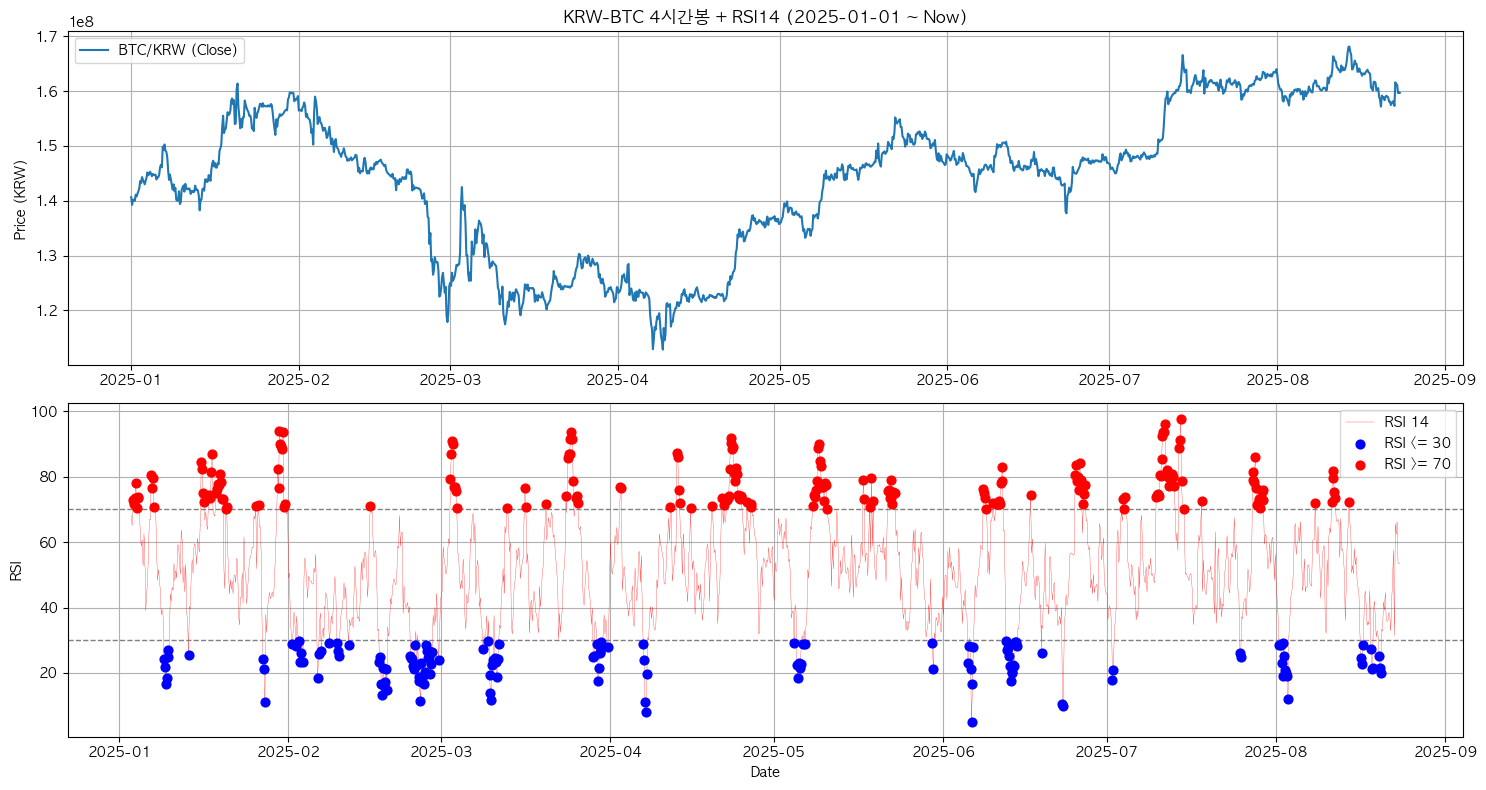

📊 과매도 구간 개수 (RSI <= 30): 139
📊 과매수 구간 개수 (RSI >= 70): 201


In [54]:
# 4️⃣ 차트 그리기
plt.figure(figsize=(15,8))

# (a) 가격 차트
plt.subplot(2,1,1)
plt.plot(df.index, df["close"], label="BTC/KRW (Close)")
plt.title("KRW-BTC 4시간봉 + RSI14 (2025-01-01 ~ Now)")
plt.ylabel("Price (KRW)")
plt.legend()
plt.grid(True)

# (b) RSI 차트
plt.subplot(2,1,2)
plt.plot(df.index, df["RSI14"], color="red", label="RSI 14", linewidth=0.2)
plt.axhline(70, color="gray", linestyle="--", linewidth=1)  # 과매수 기준선
plt.axhline(30, color="gray", linestyle="--", linewidth=1)  # 과매도 기준선

# 🔹 과매도 지점 (RSI <= 30)
oversold = df[df["RSI14"] <= 30]
plt.scatter(oversold.index, oversold["RSI14"], color="blue", s=40, zorder=5, label="RSI <= 30")

# 🔹 과매수 지점 (RSI >= 70)
overbought = df[df["RSI14"] >= 70]
plt.scatter(overbought.index, overbought["RSI14"], color="red", s=40, zorder=5, label="RSI >= 70")

plt.ylabel("RSI")
plt.xlabel("Date")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 🔹 개수 카운트 출력
print(f"📊 과매도 구간 개수 (RSI <= 30): {len(oversold)}")
print(f"📊 과매수 구간 개수 (RSI >= 70): {len(overbought)}")



In [48]:
capital = 1_000_000   # 초기 자본 100만원
position = 0          # BTC 보유 수량
avg_buy_price = 0     # 평균 매수가

for i in range(len(df)):
    rsi = df["RSI14"].iloc[i]
    price = df["close"].iloc[i]

    # 매수 조건: RSI <= 30
    if rsi <= 30 and capital > 0:
        invest_amount = capital * 0.2        # 남은 원금의 20%
        btc_amount = invest_amount / price   # 매수 수량

        # 평균 매수가 갱신 (가중평균)
        total_cost = (avg_buy_price * position) + invest_amount
        position += btc_amount
        avg_buy_price = total_cost / position

        capital -= invest_amount
        print(f"{df.index[i]} 매수: {price:.0f}원 | 매수 금액: {invest_amount:.0f}원 | 평균 단가: {avg_buy_price:.0f}원 | 잔여 현금: {capital:.0f}원")

    # 매도 조건: RSI >= 70
    elif rsi >= 70 and position > 0:
        sell_value = position * price
        capital += sell_value
        profit = (price - avg_buy_price) / avg_buy_price * 100
        print(f"{df.index[i]} 매도: {price:.0f}원 | 매도 금액: {sell_value:,.0f}원 | 수익률: {profit:.2f}%")
        position = 0
        avg_buy_price = 0   # 매도 후 평균 단가 리셋

# 🔹 시뮬레이션 종료 후 최종 평가 금액 계산
final_value = capital + (position * df["close"].iloc[-1])
print("\n===============================")
print(f"💰 최종 평가 금액: {final_value:,.0f} 원")
print(f"📈 총 수익률: {(final_value - 1_000_000) / 1_000_000 * 100:.2f}%")


2025-01-09 05:00:00 매수: 142368000원 | 매수 금액: 200000원 | 평균 단가: 142368000원 | 잔여 현금: 800000원
2025-01-09 09:00:00 매수: 140210000원 | 매수 금액: 160000원 | 평균 단가: 141400744원 | 잔여 현금: 640000원
2025-01-09 13:00:00 매수: 140001000원 | 매수 금액: 128000원 | 평균 단가: 141030897원 | 잔여 현금: 512000원
2025-01-09 17:00:00 매수: 140109000원 | 매수 금액: 102400원 | 평균 단가: 140870133원 | 잔여 현금: 409600원
2025-01-09 21:00:00 매수: 141738000원 | 매수 금액: 81920원 | 평균 단가: 140975311원 | 잔여 현금: 327680원
2025-01-10 01:00:00 매수: 139401000원 | 매수 금액: 65536원 | 평균 단가: 140834044원 | 잔여 현금: 262144원
2025-01-13 17:00:00 매수: 138262000원 | 매수 금액: 52429원 | 평균 단가: 140660450원 | 잔여 현금: 209715원
2025-01-16 01:00:00 매도: 146857000원 | 매도 금액: 825,099원 | 수익률: 4.41%
2025-01-27 09:00:00 매수: 154467000원 | 매수 금액: 206963원 | 평균 단가: 154467000원 | 잔여 현금: 827852원
2025-01-27 13:00:00 매수: 153131000원 | 매수 금액: 165570원 | 평균 단가: 153870355원 | 잔여 현금: 662281원
2025-01-27 17:00:00 매수: 152010000원 | 매수 금액: 132456원 | 평균 단가: 153378002원 | 잔여 현금: 529825원
2025-01-30 01:00:00 매도: 158460000원 | 매도 금액: 521

In [49]:
capital = 1_000_000   # 초기 자본 100만원
position = 0          # BTC 보유 수량
avg_buy_price = 0     # 평균 매수가

for i in range(len(df)):
    rsi = df["RSI14"].iloc[i]
    price = df["close"].iloc[i]

    # 매수 조건: RSI <= 30
    if rsi <= 30 and capital > 0:
        invest_amount = capital * 0.2        # 남은 원금의 20%
        btc_amount = invest_amount / price

        # 평균 매수가 갱신
        total_cost = (avg_buy_price * position) + invest_amount
        position += btc_amount
        avg_buy_price = total_cost / position

        capital -= invest_amount
        print(f"{df.index[i]} 매수: {price:.0f}원 | 매수 금액: {invest_amount:.0f}원 | 평균 단가: {avg_buy_price:.0f}원 | 잔여 현금: {capital:.0f}원")

    # 매도 조건: RSI >= 70
    elif rsi >= 70 and position > 0:
        profit_rate = (price - avg_buy_price) / avg_buy_price * 100  # 수익률 계산

        if profit_rate <= 0:
            # 🔹 손실 또는 본전 → 전량 매도
            sell_value = position * price
            capital += sell_value
            print(f"{df.index[i]} 전량 매도(손실/본전): {price:.0f}원 | 매도 금액: {sell_value:,.0f}원 | 수익률: {profit_rate:.2f}%")
            position = 0
            avg_buy_price = 0

        elif profit_rate >= 25:
            # 🔹 수익률 25% 이상 → 절반만 매도
            sell_amount = position / 2
            sell_value = sell_amount * price
            capital += sell_value
            position -= sell_amount
            print(f"{df.index[i]} 절반 매도(익절): {price:.0f}원 | 매도 금액: {sell_value:,.0f}원 | 남은 BTC: {position:.6f} | 수익률: {profit_rate:.2f}%")

# 🔹 시뮬레이션 종료 후 최종 평가 금액 계산
final_value = capital + (position * df["close"].iloc[-1])
print("\n===============================")
print(f"💰 최종 평가 금액: {final_value:,.0f} 원")
print(f"📈 총 수익률: {(final_value - 1_000_000) / 1_000_000 * 100:.2f}%")


2025-01-09 05:00:00 매수: 142368000원 | 매수 금액: 200000원 | 평균 단가: 142368000원 | 잔여 현금: 800000원
2025-01-09 09:00:00 매수: 140210000원 | 매수 금액: 160000원 | 평균 단가: 141400744원 | 잔여 현금: 640000원
2025-01-09 13:00:00 매수: 140001000원 | 매수 금액: 128000원 | 평균 단가: 141030897원 | 잔여 현금: 512000원
2025-01-09 17:00:00 매수: 140109000원 | 매수 금액: 102400원 | 평균 단가: 140870133원 | 잔여 현금: 409600원
2025-01-09 21:00:00 매수: 141738000원 | 매수 금액: 81920원 | 평균 단가: 140975311원 | 잔여 현금: 327680원
2025-01-10 01:00:00 매수: 139401000원 | 매수 금액: 65536원 | 평균 단가: 140834044원 | 잔여 현금: 262144원
2025-01-13 17:00:00 매수: 138262000원 | 매수 금액: 52429원 | 평균 단가: 140660450원 | 잔여 현금: 209715원
2025-01-27 09:00:00 매수: 154467000원 | 매수 금액: 41943원 | 평균 단가: 141296952원 | 잔여 현금: 167772원
2025-01-27 13:00:00 매수: 153131000원 | 매수 금액: 33554원 | 평균 단가: 141721422원 | 잔여 현금: 134218원
2025-01-27 17:00:00 매수: 152010000원 | 매수 금액: 26844원 | 평균 단가: 142010473원 | 잔여 현금: 107374원
2025-02-01 17:00:00 매수: 156939000원 | 매수 금액: 21475원 | 평균 단가: 142328536원 | 잔여 현금: 85899원
2025-02-02 09:00:00 매수: 15531

In [55]:
# 수수료 반영
capital = 1_000_000   # 초기 자본 100만원
position = 0          # BTC 보유 수량
avg_buy_price = 0     # 평균 매수가
fee = 0.0005          # 업비트 시장가 수수료 0.05%

for i in range(len(df)):
    rsi = df["RSI14"].iloc[i]
    price = df["close"].iloc[i]

    # 매수 조건: RSI <= 30
    if rsi <= 30 and capital > 0:
        invest_amount = capital * 0.2
        btc_amount = (invest_amount * (1 - fee)) / price   # 수수료 반영
        total_cost = (avg_buy_price * position) + invest_amount
        position += btc_amount
        avg_buy_price = total_cost / position
        capital -= invest_amount
        print(f"{df.index[i]} 매수: {price:.0f}원 | 매수 금액: {invest_amount:.0f}원 | 평균 단가: {avg_buy_price:.0f}원 | 잔여 현금: {capital:.0f}원")

    # 매도 조건: RSI >= 70
    elif rsi >= 70 and position > 0:
        profit_rate = (price - avg_buy_price) / avg_buy_price * 100

        if profit_rate <= 0:
            # 🔹 전량 매도
            sell_value = (position * price) * (1 - fee)   # 수수료 반영
            capital += sell_value
            print(f"{df.index[i]} 전량 매도(손실/본전): {price:.0f}원 | 매도 금액: {sell_value:,.0f}원 | 수익률: {profit_rate:.2f}%")
            position = 0
            avg_buy_price = 0

        elif profit_rate >= 25:
            # 🔹 절반 매도
            sell_amount = position / 2
            sell_value = (sell_amount * price) * (1 - fee)  # 수수료 반영
            capital += sell_value
            position -= sell_amount
            print(f"{df.index[i]} 절반 매도(익절): {price:.0f}원 | 매도 금액: {sell_value:,.0f}원 | 남은 BTC: {position:.6f} | 수익률: {profit_rate:.2f}%")

# 🔹 시뮬레이션 종료 후 최종 평가 금액 계산
final_value = capital + (position * df["close"].iloc[-1])
print("\n===============================")
print(f"💰 최종 평가 금액: {final_value:,.0f} 원")
print(f"📈 총 수익률: {(final_value - 1_000_000) / 1_000_000 * 100:.2f}%")


2025-01-09 05:00:00 매수: 142368000원 | 매수 금액: 200000원 | 평균 단가: 142439220원 | 잔여 현금: 800000원
2025-01-09 09:00:00 매수: 140210000원 | 매수 금액: 160000원 | 평균 단가: 141471479원 | 잔여 현금: 640000원
2025-01-09 13:00:00 매수: 140001000원 | 매수 금액: 128000원 | 평균 단가: 141101448원 | 잔여 현금: 512000원
2025-01-09 17:00:00 매수: 140109000원 | 매수 금액: 102400원 | 평균 단가: 140940603원 | 잔여 현금: 409600원
2025-01-09 21:00:00 매수: 141738000원 | 매수 금액: 81920원 | 평균 단가: 141045834원 | 잔여 현금: 327680원
2025-01-10 01:00:00 매수: 139401000원 | 매수 금액: 65536원 | 평균 단가: 140904496원 | 잔여 현금: 262144원
2025-01-13 17:00:00 매수: 138262000원 | 매수 금액: 52429원 | 평균 단가: 140730815원 | 잔여 현금: 209715원
2025-01-27 09:00:00 매수: 154467000원 | 매수 금액: 41943원 | 평균 단가: 141367636원 | 잔여 현금: 167772원
2025-01-27 13:00:00 매수: 153131000원 | 매수 금액: 33554원 | 평균 단가: 141792318원 | 잔여 현금: 134218원
2025-01-27 17:00:00 매수: 152010000원 | 매수 금액: 26844원 | 평균 단가: 142081514원 | 잔여 현금: 107374원
2025-02-01 17:00:00 매수: 156939000원 | 매수 금액: 21475원 | 평균 단가: 142399736원 | 잔여 현금: 85899원
2025-02-02 09:00:00 매수: 15531